In [ ]:
# ==================================
# Basic tools
# ==================================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# ==================================
# Visualization
# ==================================
import matplotlib.pyplot as plt
import seaborn as sns

# ==================================
# Statistical tools
# ==================================
from scipy.stats import (
    ttest_ind,
    levene,
    chi2_contingency,
    skew,
    kurtosis,
    pearsonr,
    f_oneway
)

# ==================================
# Time Series (ARIMA / SARIMAX)
# ==================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==================================
# Machine Learning tools
# ==================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==================================
# Deep Learning (TensorFlow/Keras)
# ==================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# After mounting, you can access files from your Google Drive.
# Replace 'My Drive/household.csv' with the actual path to your file in Google Drive.
df = pd.read_csv('/content/household.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,active_power,current,voltage,reactive_power,apparent_power,power_factor,main,description,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
0,11/5/2022 14:05,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.5,1013,39,0.0,0,29.63,27.97
1,11/5/2022 14:06,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.5,1013,39,0.0,0,29.63,27.97
2,11/5/2022 14:07,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.5,1013,39,0.0,0,29.63,27.97
3,11/5/2022 14:08,640.0,5.45,120.7,152.08,657.82,0.9729,Clear,clear sky,24.19,23.68,23.44,27.5,1013,39,0.0,0,29.63,27.97
4,11/5/2022 14:09,257.6,2.47,122.4,158.26,302.33,0.8520,Clear,clear sky,24.19,23.68,23.44,27.5,1013,39,0.0,0,29.63,27.97


In [ ]:
df = df.drop([
    'main', 'description', 'temp_min', 'temp_max',
    'temp_t+1', 'feels_like_t+1', 'deg', 'current',
    'voltage', 'reactive_power', 'apparent_power',
    'power_factor'
], axis=1, errors='ignore')


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')


In [ ]:
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)


In [ ]:
df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)


In [ ]:
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)       # previous hour impact
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)     # 24-hour cycle
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()

df_hour = df_hour.dropna()


In [ ]:
features = [
    'active_power', 'temp', 'humidity',
    'pressure', 'speed',
    'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h'
]

df_lstm = df_hour[features].copy()


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)


/tmp/ipython-input-1808504416.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Total sequences: 10088
Train: (8574, 24, 8) Val: (1009, 24, 8) Test: (505, 24, 8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0176 - mae: 0.1014 - val_loss: 0.0088 - val_mae: 0.0750
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0120 - mae: 0.0857 - val_loss: 0.0084 - val_mae: 0.0723
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0114 - mae: 0.0835 - val_loss: 0.0081 - val_mae: 0.0702
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0111 - mae: 0.0825 - val_loss: 0.0078 - val_mae: 0.0695
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0107 - mae: 0.0814 - val_loss: 0.0075 - val_mae: 0.0679
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0104 - mae: 0.0802 - val_loss: 0.0072 - val_mae: 0.0665
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0099 - mae: 0.0787 - val_loss: 0.0070 - val_mae: 0.0655
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0096 - mae: 0.0776 - val_loss: 0.0069 - val_mae: 0.0652
Epoch 9/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 7s 27

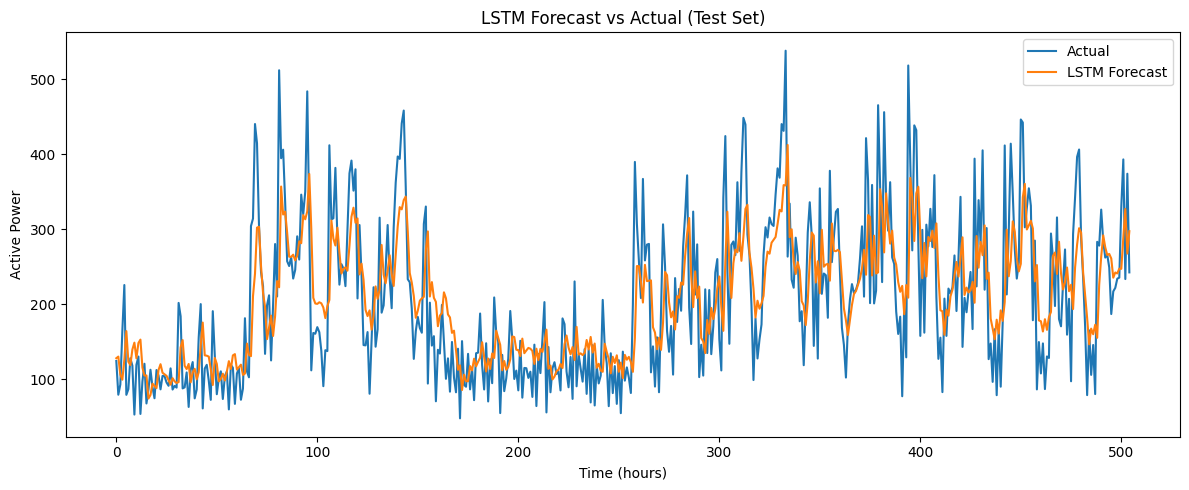

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Start of fix: Re-define df and df_hour for self-contained execution ---
# Assuming 'household.csv' is accessible, or mounted drive is handled by another cell
df = pd.read_csv('/content/household.csv')

# Dropping unnecessary columns
df = df.drop([
    'main', 'description', 'temp_min', 'temp_max',
    'temp_t+1', 'feels_like_t+1', 'deg', 'current',
    'voltage', 'reactive_power', 'apparent_power',
    'power_factor'
], axis=1, errors='ignore')

# Convert 'date' to datetime and sort
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# Resample to hourly data
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)

# Add weekday and is_weekend features
df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Add lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)       # previous hour impact
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)     # 24-hour cycle
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()

df_hour = df_hour.dropna()
# --- End of fix: df_hour is now defined ---

# ======================================
# 1. Select features for LSTM
# ======================================
features = [
    'active_power',
    'temp', 'humidity', 'pressure', 'speed',
    'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h'
]

df_lstm = df_hour[features].dropna().copy()

# ======================================
# 2. Scale data
# (here we scale all features, if you want to be more "proper"
#  you can fit scaler on train then
#  transform val/test)
# ======================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm.values)

# ======================================
# 3. Create sequences (windows)
# use past 24 hours to predict the next hour
# ======================================
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])  # 24h before
        y.append(data[i, 0])                # column 0 = active_power
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size)

print("Total sequences:", X.shape[0])

# ======================================
# 4. Split train/val/test by TIME ORDER
#    85% train – 10% validate – 5% test
# ======================================
n_total = len(X)
train_end = int(0.85 * n_total)
val_end   = int(0.95 * n_total)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print("Train:", X_train.shape,
      "Val:", X_val.shape,
      "Test:", X_test.shape)

# ======================================
# 5. Build LSTM architecture
#    LSTM(64) -> Dropout -> LSTM(32) -> Dropout -> Dense(1)
# ======================================
model = Sequential()
model.add(LSTM(64, return_sequences=True,
               input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))  # one-step forecast

model.summary()

# ======================================
# 6. Compile model
#    - Optimizer: Adam
#    - Loss: MSE
#    - Metrics: MAE (to monitor)
# ======================================
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# (optional) early stopping to avoid overfitting
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights=True)

# ======================================
# 7. Train model
#    - 20 epochs
#    - batch_size = 32
#    - DO NOT shuffle to keep the correct time order
# ======================================
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[es],
    verbose=1
)

# ======================================
# 8. Forecast on test set
# ======================================
y_pred_scaled = model.predict(X_test)

# ======================================
# 9. Inverse scale to original units (kW, kWh, ...)
#    Because the scaler was fit on all features, we need to
#    "reconstruct" the full matrix to use inverse_transform
# ======================================
# Prepare full array for y_test
test_full = np.zeros((len(y_test), scaled_data.shape[1]))
test_full[:, 0] = y_test
y_test_inv = scaler.inverse_transform(test_full)[:, 0]

# Prepare full array for y_pred
pred_full = np.zeros_like(test_full)
pred_full[:, 0] = y_pred_scaled[:, 0]
y_pred_inv = scaler.inverse_transform(pred_full)[:, 0]

# ======================================
# 10. Evaluate: MAE, MSE, RMSE, MAPE
# ======================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing 0s in y_true with a small epsilon or filtering
    # For simplicity, we'll filter out y_true values that are 0.
    # A more robust solution might involve handling division by zero explicitly or using a symmetric MAPE variant.
    non_zero_indices = y_true != 0
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"LSTM (1-step) – MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# ======================================
# 11. Plot comparison: Actual vs Forecast
# ======================================
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual (Test Set)')
plt.xlabel('Time (hours)')
plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.show()

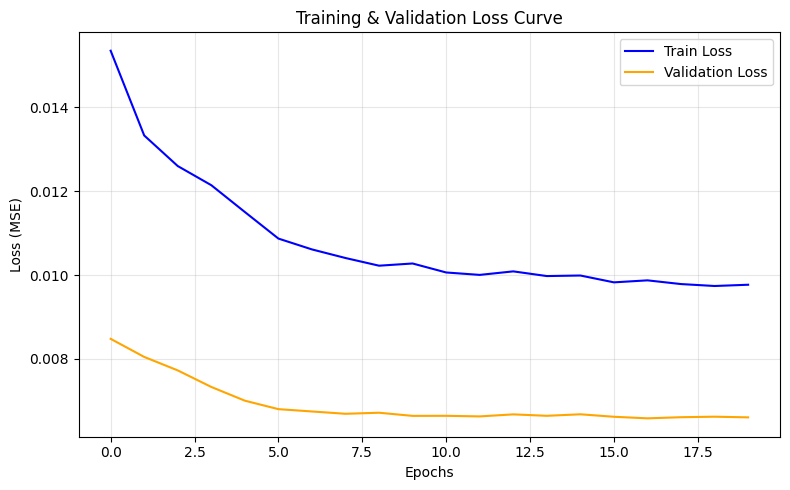

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training & Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


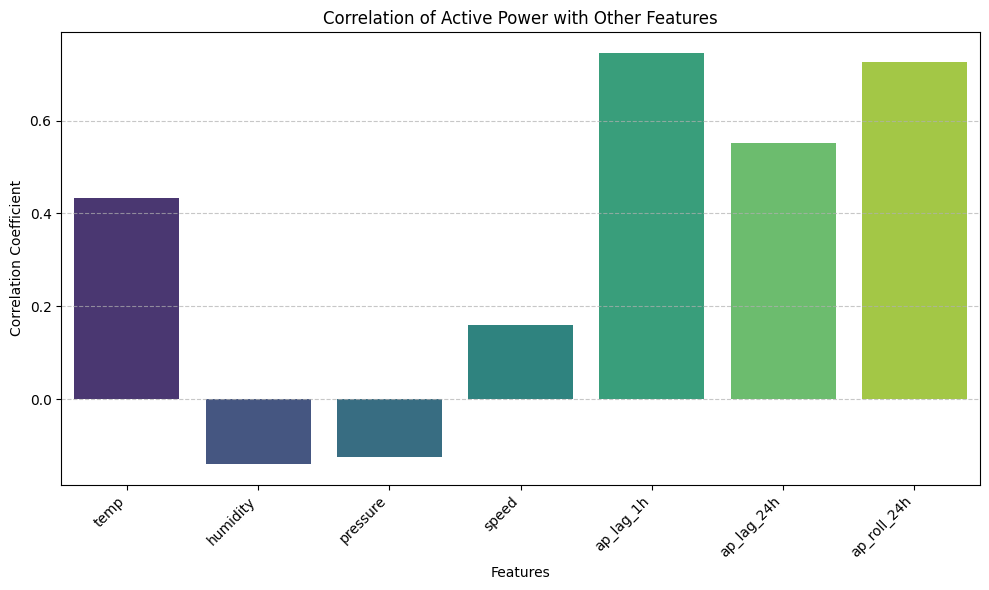

In [ ]:
correlation_matrix = df_lstm.corr()
active_power_corr = correlation_matrix['active_power'].drop('active_power')

plt.figure(figsize=(10, 6))
sns.barplot(x=active_power_corr.index, y=active_power_corr.values, palette='viridis')
plt.title('Correlation of Active Power with Other Features')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()